In [5]:
%matplotlib inline
import eddydiff as ed
import matplotlib.pyplot as plt
import xarray as xr

In [6]:
plt.rcParams["figure.dpi"] = 140
plt.rcParams["figure.facecolor"] = (0.91, 0.91, 0.91)
plt.rcParams["axes.facecolor"] = (0.99,)*3
plt.rcParams["grid.color"] = (0.25,)*3
plt.rcParams["grid.alpha"] = 0.3

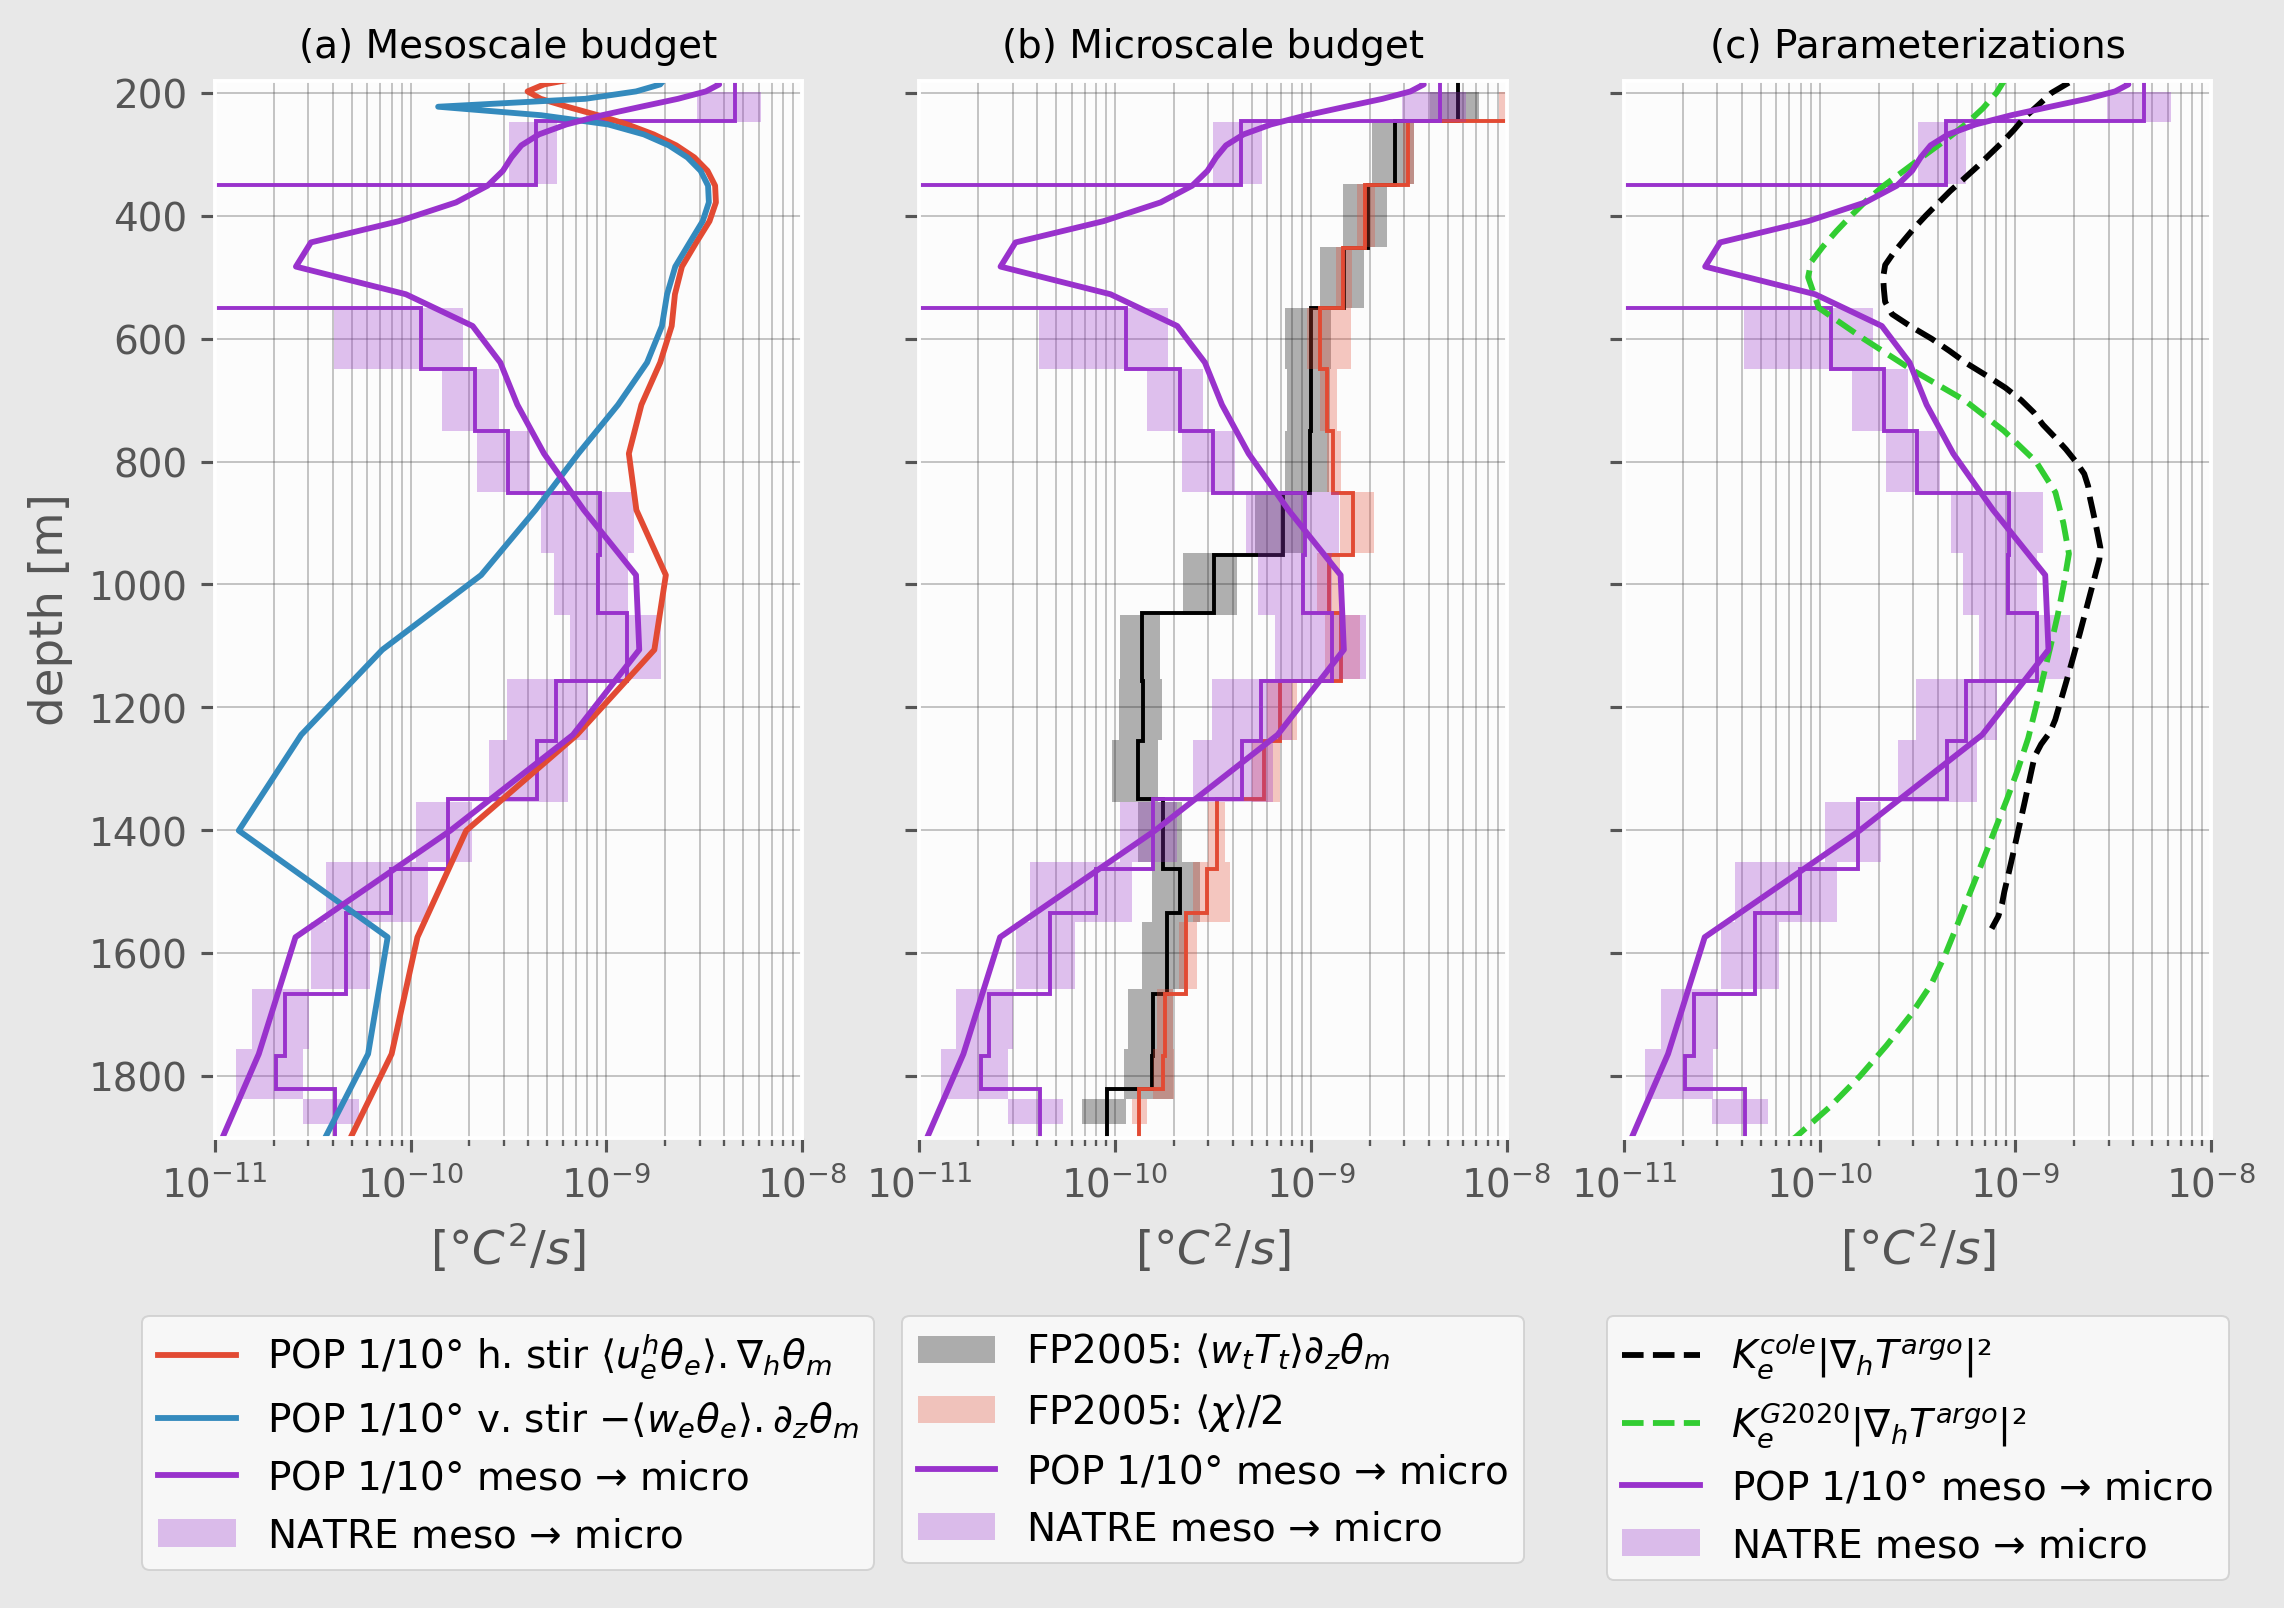

In [53]:
micro.pres.attrs["bounds"] = "pres_err"

def plot_pop_natre_meso_micro(ax):
    mesomicrocolor = "darkorchid"
    (-1 * pop_natre.DISS).cf.plot(
        ax=ax, lw=1.5, color=mesomicrocolor, label="POP 1/10° meso $→$ micro"
    )

    dcpy.plots.fill_between_bounds(
        micro,
        "residual",
        y="pres",
        color=mesomicrocolor,
        label="NATRE meso $→$ micro",
        ax=ax,
    )


f, ax = plt.subplots(1, 3, sharey=True, sharex=True, constrained_layout=False)

### Mesoscale budget
pop_natre.BC.cf.plot(ax=ax[0], label="POP 1/10° h. stir $⟨u_e^h θ_e⟩.∇_hθ_m$")
(np.abs(pop_natre.PKC)).cf.plot(ax=ax[0], label="POP 1/10° v. stir $-⟨w_eθ_e⟩.∂_zθ_m$")
#(-1 * pop_natre.VMIX).cf.plot(color="sienna", ax=ax[0], label="POP VMIX")
#(-1 * pop_natre.HDIFF).cf.plot(ax=ax[0], label="POP HDIFF", marker="x", ls="none")


### Microscale budget
plt.sca(ax[1])

dcpy.plots.fill_between_bounds(
    micro, "KρTz2", y="pres", color="k", label="FP2005: $⟨w_t T_t⟩ ∂_zθ_m$"
)
dcpy.plots.fill_between_bounds(
    micro, "chib2", y="pres", color="C0", label="FP2005: $⟨χ⟩/2$"
)

### Parameterizations
cole_var.plot(
    y="pres", label="$K_e^{cole} |∇_hT^{argo}|²$", color="k", ls="--", ax=ax[2]
)
#groeskamp.eddy_var_0.plot(
#    y="pres",
#    label="$K_e^{G2020unsupp} |∇_hT^{cole}|²$",
#    color="limegreen",
#    ls="-.",
#    ax=ax[2],
#)
groeskamp.eddy_var.plot(
    y="pres", label="$K_e^{G2020} |∇_hT^{argo}|²$", color="limegreen", ls="--", ax=ax[2]
)

### Cleanup
for idx, axx in enumerate(ax):
    plot_pop_natre_meso_micro(axx)
    axx.set_xscale("log")
    axx.set_xlabel("")
    axx.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
    axx.grid(True, which="both", lw=0.5)
    axx.set_xlabel("[$°C^2/s$]")
# ax[1].set_xlabel("Variance production or dissipation [°C²/s]")

#f.suptitle("NATRE")
ax[0].set_title("(a) Mesoscale budget", fontsize="medium")
ax[1].set_title("(b) Microscale budget", fontsize="medium")
ax[2].set_title("(c) Parameterizations", fontsize="medium")

ax[0].set_xlim([1e-11, 1e-8])
ax[0].set_ylim([1900, 180])

dcpy.plots.clean_axes(ax)
f.set_size_inches((9.2, 5))
# f.savefig("../images/natre-meso-micro-param.png")

In [ ]:
v

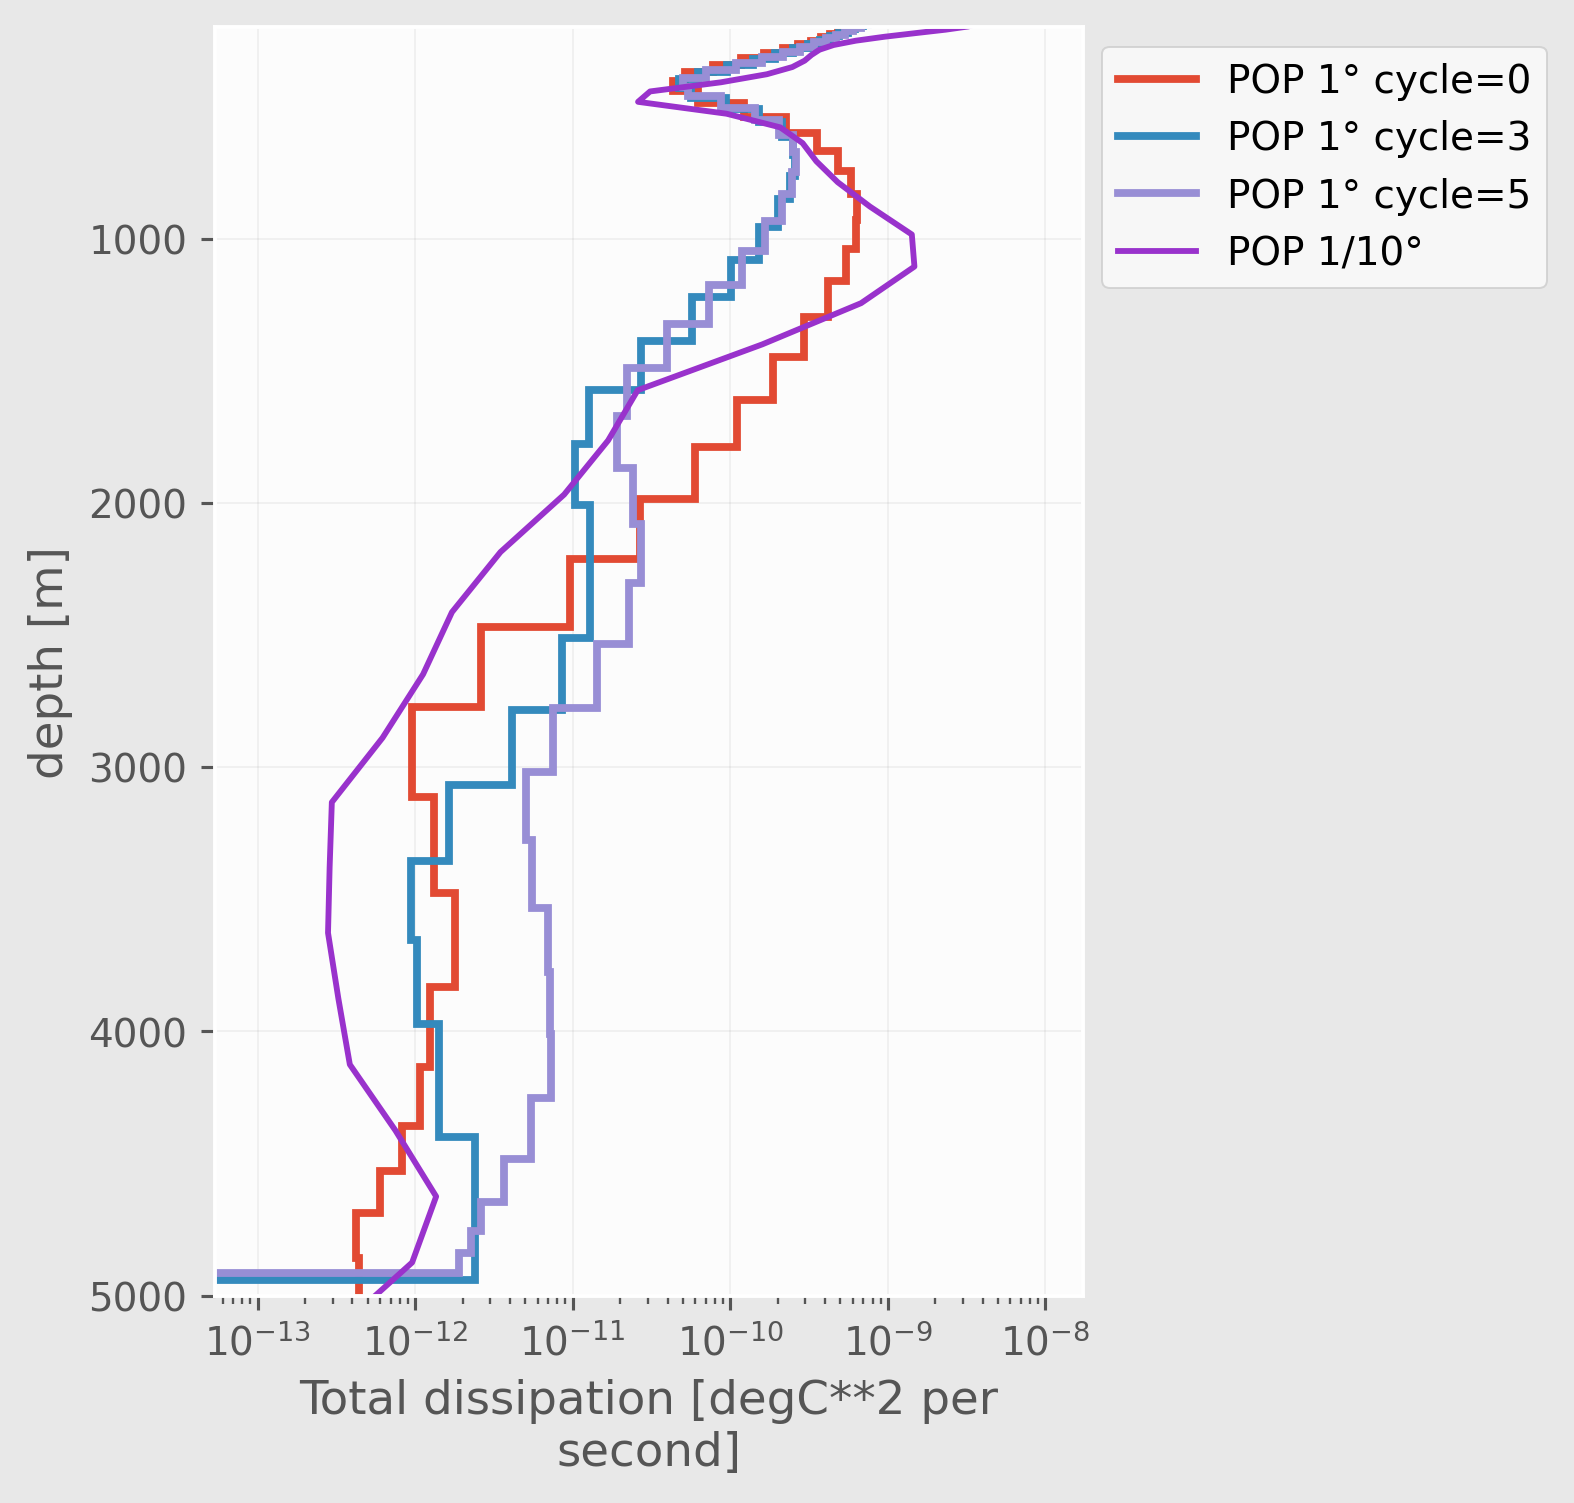

In [58]:
f, ax = plt.subplots(1, 1)

for cycle in [0, 3, 5]:
    pop = pop_1deg_natre.isel(cycle=cycle)
    pop = pop.where(pop.z_t.notnull(), drop=True)
    pop = pop.cf.add_bounds("z_t")
    ybounds = pop.z_t_bounds
    bdim = pop.cf.get_bounds_dim_name("z_t")
    yedges = np.append(ybounds.isel({bdim: 0}).data, ybounds[-1, -1])
    ax.stairs(
        pop.RediVar,
        edges=yedges,
        orientation="horizontal",
        lw=2,
        label=f"POP 1° cycle={cycle}",
    )
ax.set_ylim((5000, 200))

mesomicrocolor = "darkorchid"
(-1 * pop_natre.DISS).cf.plot(ax=ax, lw=1.5, color=mesomicrocolor, label="POP 1/10°")
ax.set_xscale("log")
ax.legend(bbox_to_anchor=(1,1))
f.set_size_inches((4, 6))

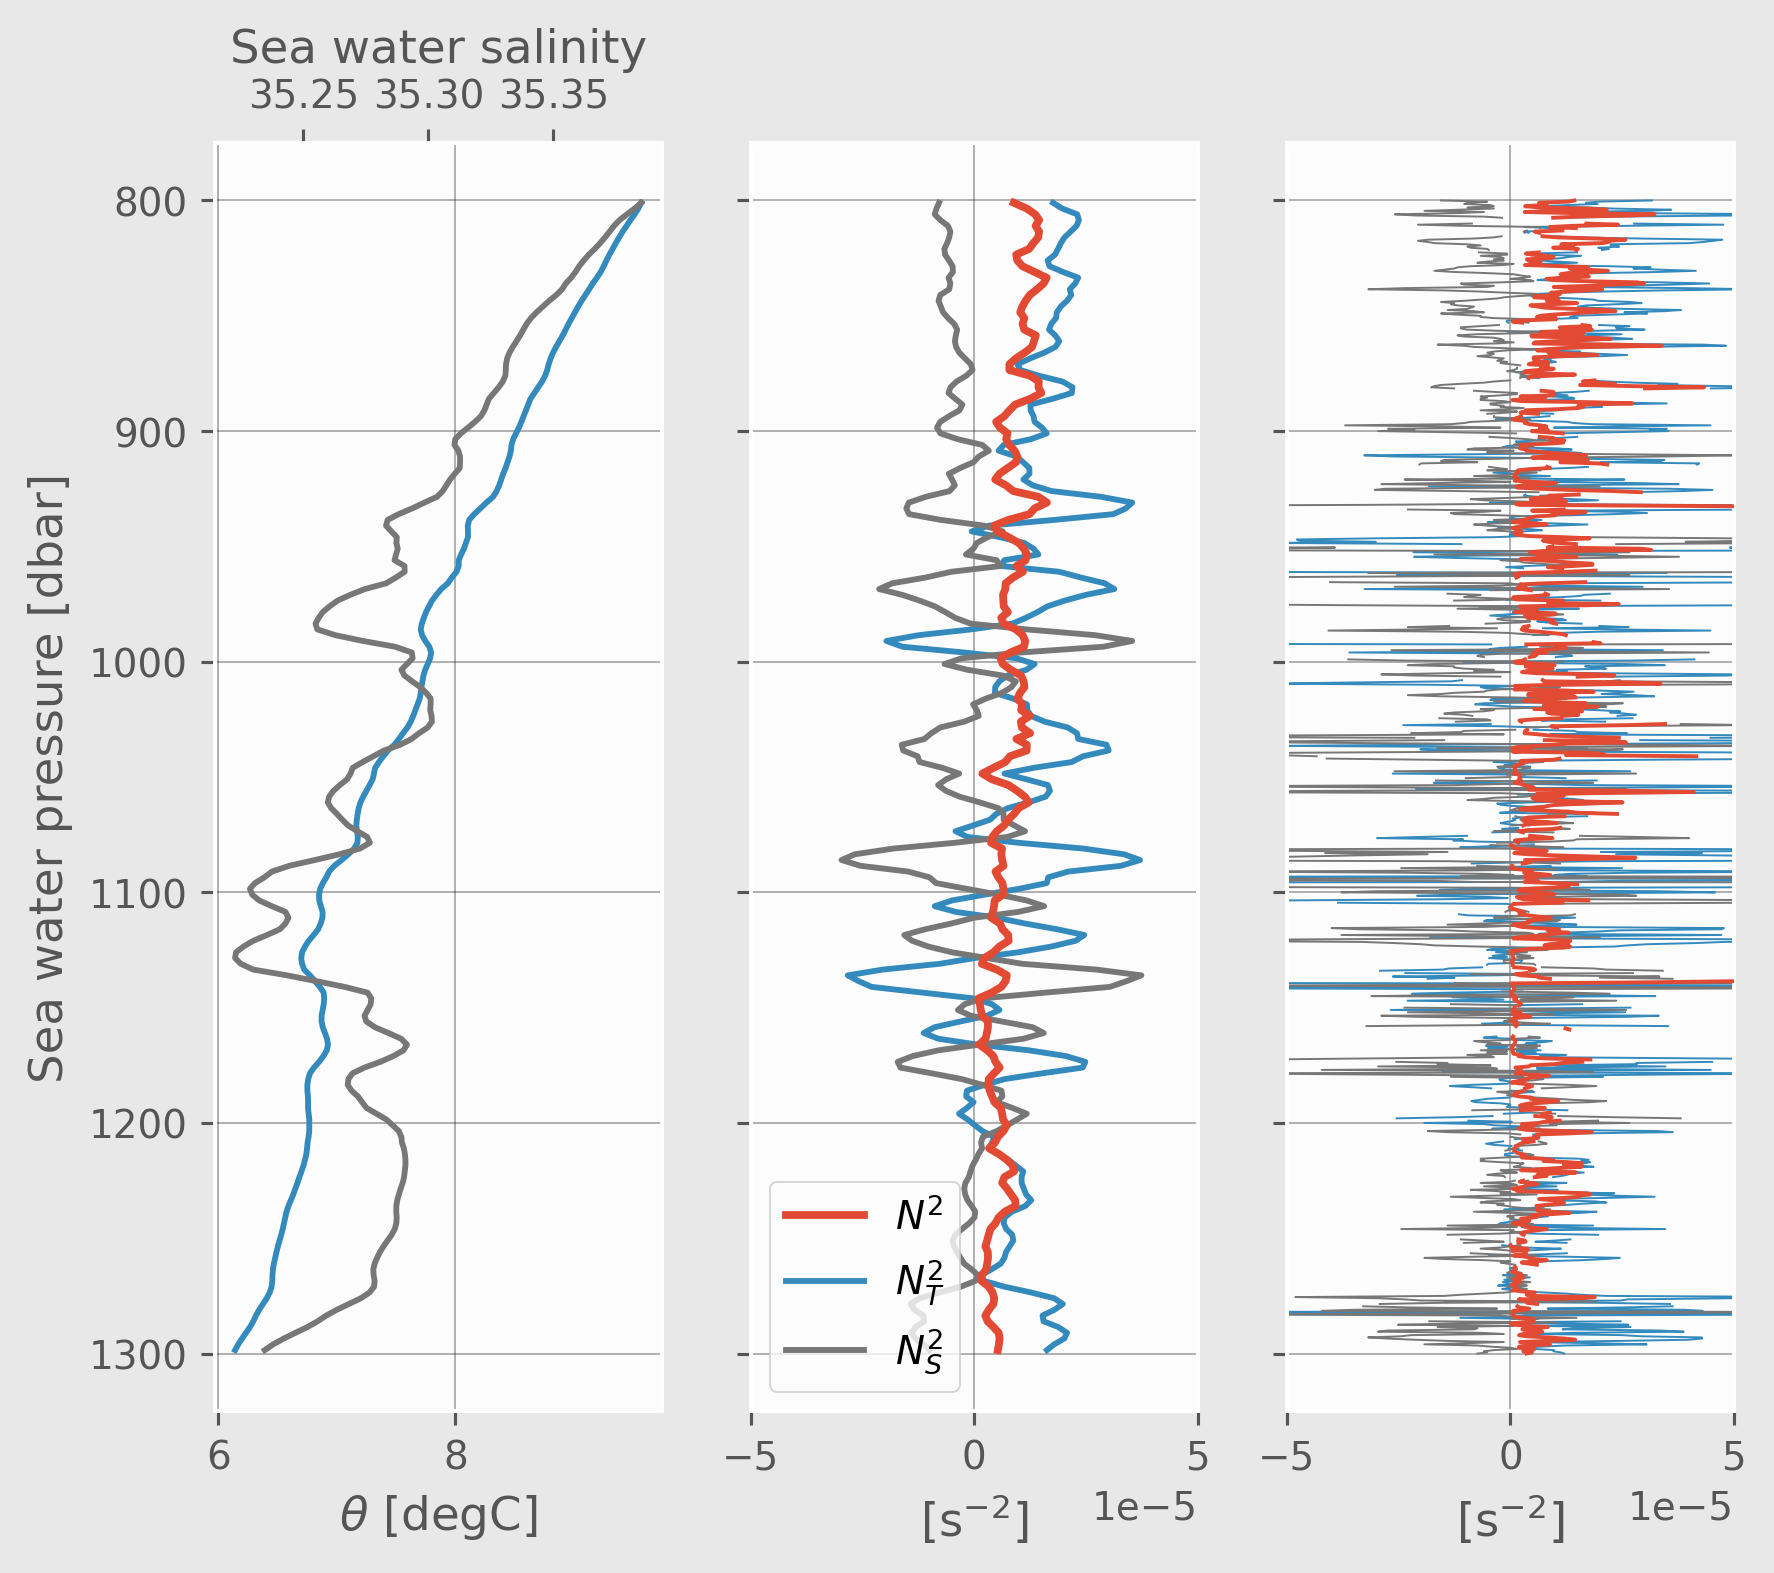

In [88]:
profile = natre.isel(latitude=3, longitude=6)

profile["NT2"] = (
    -9.81
    * dcpy.eos.alpha(profile.salt, profile.temp, profile.pres)
    * profile.theta.interpolate_na("pres").differentiate("pres")
)
profile["NS2"] = (
    9.81
    * dcpy.eos.beta(profile.salt, profile.temp, profile.pres)
    * profile.salt.interpolate_na("pres").differentiate("pres")
)

smoothed = (
    profile
    .rolling(pres=21, center=True, min_periods=1)
    .mean()
    .coarsen(pres=5, boundary="trim")
    .mean()
    .sel(pres=slice(800, 1300))
)

smoothed["NT2"] = (
    -9.81
    * dcpy.eos.alpha(smoothed.salt, smoothed.temp, smoothed.pres)
    * smoothed.theta.interpolate_na("pres").differentiate("pres")
)
smoothed["NS2"] = (
    9.81
    * dcpy.eos.beta(smoothed.salt, smoothed.temp, smoothed.pres)
    * smoothed.salt.interpolate_na("pres").differentiate("pres")
)

f, ax = plt.subplots(1, 3, sharey=True)

smoothed.theta.cf.plot(ax=ax[0], color="C1")

axS = ax[0].twiny()
axS.grid(False)
smoothed.salt.cf.plot(color="C3", ax=axS)

# ax2 = ax[0].twiny()
# smoothed.gamma_n.cf.plot(color="k", ax=ax2)
# ax2.grid(False)

smoothed.N2.cf.plot(lw=2, zorder=5, ax=ax[1])
smoothed.NT2.cf.plot(ax=ax[1])
smoothed.NS2.cf.plot(color="C3", ax=ax[1])
ax[1].set_xlim([-5e-5, 5e-5])
ax[1].legend(["$N^2$", "$N_T^2$", "$N_S^2$"])

profile.N2.sel(pres=slice(800, 1300)).cf.plot(lw=1, zorder=5, ax=ax[2])
profile.NT2.sel(pres=slice(800, 1300)).cf.plot(ax=ax[2], lw=0.5)
profile.NS2.sel(pres=slice(800, 1300)).cf.plot(color="C3", ax=ax[2], lw=0.5)
ax[2].set_xlim([-5e-5, 5e-5])
#ax[2].legend(["$N^2$", "$N_T^2$", "$N_S^2$"])

dcpy.plots.clean_axes(ax)
[aa.set_title("") for aa in ax]
axS.set_title("")
ax[1].set_xlabel("[s$^{-2}$]")

f.set_size_inches((7, 6))

### Nice matplotlib map

In [7]:
import cartopy.crs as ccrs

natre = ed.natre.read_natre()
lats, lons = np.meshgrid(natre.latitude, natre.longitude)

a05 = xr.load_dataset("../datasets/a05-section.nc").query({"cast": "longitude > -35"})
with_chi = a05[["latitude", "longitude"]].where(
    a05.chi.count("pressure") > 0, drop=True
)


plt.rcParams["axes.facecolor"] = "none"

f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

topo.plot(
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    vmin=-5000,
    vmax=5000,
    cmap="RdBu_r",
    center=0,
)

topo.plot.contour(transform=ccrs.PlateCarree(), levels=[0], colors="k")


(h1,) = ax.plot(
    lons.ravel(),
    lats.ravel(),
    color="w",
    marker="o",
    ls="none",
    ms=2,
    transform=ccrs.PlateCarree(),
)

(h0,) = ax.plot(
    a05.longitude, a05.latitude, marker=".", lw=0.5, transform=ccrs.PlateCarree()
)
(h1,) = ax.plot(
    with_chi.longitude,
    with_chi.latitude,
    color="k",
    ls="none",
    ms=4,
    marker=".",
    transform=ccrs.PlateCarree(),
)

for cast in with_chi.cast.data:
    subset = with_chi.sel(cast=cast)
    ax.text(
        subset.longitude,
        subset.latitude - 0.75,
        str(cast),
        rotation=45,
        fontsize=5,
        color="w",
        va="top",
        ha="right",
    )
f.savefig("../images/A05-NATRE-domain.png")

# ax.legend([h0, h1], ["GO-SHIP A05", "NATRE"])

KeyError: "Dataset.cf does not understand the key 'sea_water_salinity'. Use 'repr(Dataset.cf)' (or 'Dataset.cf' in a Jupyter environment) to see a list of key names that can be interpreted."